## Pulse programming in Qiskit

Agenda
- SuperstaQ API
- cirq-superstaq
- qiskit superstaq
- applications-superstaq
- [Faster and More Reliable Quantum SWAPs via Native Gates](https://arxiv.org/abs/2109.13199) demo
- Work on a qiskit-superstaq issue
- Work on a cirq-superstaq issue
- Work on an applications-superstaq issue

In [12]:
!pip install matplotlib

  Using cached matplotlib-3.5.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached kiwisolver-1.3.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
     |████████████████████████████████| 895 kB 9.1 MB/s            
  Using cached Pillow-9.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


Super.tech specialty is benchmarking, searching for practical applications and cross-layer optimizations of quantum comuters. Today we are going to be focused on cross layer optimizations; but stay tuned for our benchmarking effort that's going to be released next month and the applications we'll release later this year.

We deliver our software from a server that people with access can request access to and they get and APItoken SuperstaQ is a an API for perfoming cross-layer optimizations. Now, what is cross layer optimizations? It is reaching throughout the whole stack to perform optimizations on computer programs.

We should note that everything in this paper has been published here: https://arxiv.org/abs/2109.13199

Cross layer optimization is going all across the stack. It is building applications to hardware or building hardware up to applications. The first one is called bottom up cross layer optimization and the one is called top down cross layer optimizations.

SuperstaQ provides an API that anyone can use to interface with. Anyone also gets 500 credits free credits to start playing around with once they start using SuperstaQ. So please go to superstaq.super.tech to get your API token. 

With the API we have you can interface with our clients or even build your own client. This is because we support the OpenApi standard which helps keep our documentation, client libraries and source code in sync. Our main clients are cirq-superstaq and qiskit-superstaq. Today we are going to work through an example of cross-layer optimization via qiskit . Please go get your qiskit API key and fire up your qiskit superstaq.

We are now going to run the SWAP circuit through Qiskit SuperstaQ and show you how the performance changed.
We are going to show you exactly why this SWAP circuit is more efficient using four techniques. SWAP orientation, Cross-Gate Pulse cancellation, Commutation through CR, and CR polarity.

In Qiskit you can create pulse level quantum programs to do computation. In this tutorial we are going to perform pulse level gates; which got us a top submission at the IBM SWAP Challenge. The problem is that Qiskit doesn't give users access to Cross resonance gates but Qiskit pulse does.

## Optimizing the SWAP gate

The first step in optimizing the SWAP gate is to notice that even though QASM supports gates in a certain type of way that is similar to all the SWAP gates, certain directions of the SWAP gate are faster. I'm going to first show how the SWAPs lead to a better optimization and then walk the audience through it.

In [1]:
import numpy as np
import qiskit

from qiskit_superstaq.superstaq_provider import SuperstaQProvider

In [2]:
provider = SuperstaQProvider(api_key="ya29.A0ARrdaM_ak9z-vFWsGTPT1ZVqryUP4e8QNKiGnpj7mC7a0rhdspQxZ-tEzneFU3sPcGjkkQxDJs4Xy8vz7Mx6fNvjQQAT-KNrrCZJ0QiyEoToWte21IlG2-r1rSPsr-ySBOBxZz7BMG_gatZGln2X1D2WCJsSG9k")

In [3]:
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
qiskit.IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='ornl', project='csc461')>,
 <AccountProvider for IBMQ(hub='ibm-q-startup', group='super-tech-labs', project='default')>,
 <AccountProvider for IBMQ(hub='ibm-q-startup', group='super-tech-labs', project='reservations')>]

In [5]:
provider = qiskit.IBMQ.providers()[0]

In [6]:
backend = provider.get_backend("ibmq_bogota")

We are going to first start with the SWAP circuit

In [7]:
qc = qiskit.QuantumCircuit(2, 2)
qc.swap(0, 1)
qc.measure([0, 1], [0, 1])
print(qc)

        ┌─┐   
q_0: ─X─┤M├───
      │ └╥┘┌─┐
q_1: ─X──╫─┤M├
         ║ └╥┘
c: 2/════╩══╩═
         0  1 


We are the going to draw it's pulse map and see how long it takes to execute it

In [8]:
qc = qiskit.transpile(qc, backend)

In [9]:
print(qc)

                    ┌───┐     ┌─┐   
      q_0 -> 0 ──■──┤ X ├──■──┤M├───
               ┌─┴─┐└─┬─┘┌─┴─┐└╥┘┌─┐
      q_1 -> 1 ┤ X ├──■──┤ X ├─╫─┤M├
               └───┘     └───┘ ║ └╥┘
ancilla_0 -> 2 ────────────────╫──╫─
                               ║  ║ 
ancilla_1 -> 3 ────────────────╫──╫─
                               ║  ║ 
ancilla_2 -> 4 ────────────────╫──╫─
                               ║  ║ 
          c: 2/════════════════╩══╩═
                               0  1 


In [14]:
pulse_schedule = qiskit.schedule(qc, backend)

Drive channels transmit signals to qubits which eanct gate operations

Measurement channels transmit measurement stimuls pulses for readout
Control channels provide supplementary control over the qubit to the drive channel. They are often associated with multi-qubit gate operations.

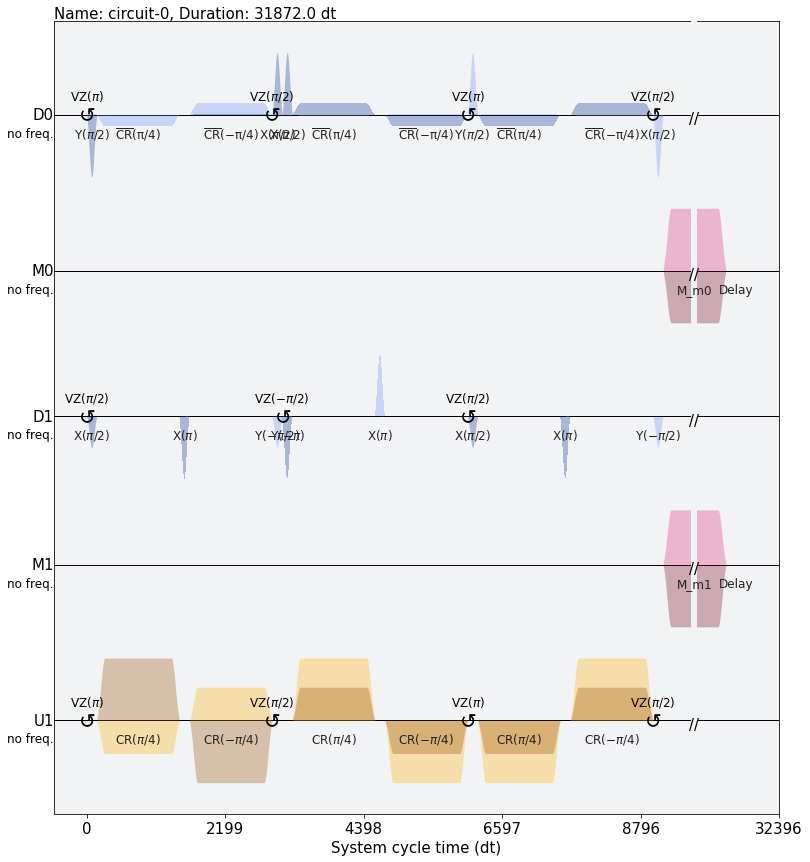

In [16]:
pulse_schedule.draw()

In [52]:
standard_orientation_duration = pulse_schedule.duration

In [53]:
ism = backend.defaults().instruction_schedule_map

In [54]:
def _is_fast_cx_orientation(i: int, j: int) -> bool:
    """Returns whether CX(i, j) is faster than CX(j, i).

    While both gates are possible on any connected qubit pairs, one orientation is faster
    than the other since the cross-resonance is directional.
    """
    return ism.get("cx", qubits=[i, j]).duration < ism.get("cx", qubits=[j, i]).duration


In [29]:
def _get_echoed_cr_schedule(i: int, j: int, *, polarity: str = "+-") -> qiskit.pulse.Schedule:
    """Applies an echoed cross resonance in either the +- or -+ polarity.

    This operation is not merely a CR90P/N; it also has a side effect of an X on the control.
    """
    assert polarity in ["+-", "-+"]
    CR45P_schedule, CR45N_schedule = _get_cr_45p_and_45n(i, j)

    schedule = CR45P_schedule if polarity == "+-" else CR45N_schedule
    schedule |= ism.get("x", qubits=[i]) << schedule.duration
    schedule |= (CR45N_schedule if polarity == "+-" else CR45P_schedule) << schedule.duration
    return schedule

In [30]:
def _get_cr_45p_and_45n(i: int, j: int):
    """Extracts the CR(+45) and CR(-45) pulse schedules from the schedule for CX(i, j).
    If the CR's are oriented in the opposite direction, returns None.
    """
    cx_schedule = ism.get("cx", qubits=[i, j])
    cr_start_index = -1

    for i, (_, instruction) in enumerate(cx_schedule.instructions):
        # the Cross-Resonance within the CNOT starts with a GaussianSquare Play instruction
        if isinstance(instruction, pulse.Play):
            if isinstance(instruction.pulse, library.parametric_pulses.GaussianSquare):
                cr_start_index = i
                break

    assert cr_start_index != -1, "did not find the start of CR"

    cr_instructions = cx_schedule.instructions[cr_start_index:]
    assert len(cr_instructions) == 5, f"{cr_instructions} should have 5 instructions"

    # first two are CR(+45), last two are CR(-45)
    CR45P_schedule = cr_instructions[0][1] + cr_instructions[1][1]
    CR45N_schedule = cr_instructions[3][1] + cr_instructions[4][1]

    return CR45P_schedule, CR45N_schedule

In [55]:
_is_fast_cx_orientation(0, 1)

False

In [56]:
_is_fast_cx_orientation(1, 0)

True

In [18]:
qc_swap_orientation = qiskit.QuantumCircuit(2, 2)
qc_swap_orientation.cnot(1, 0)
qc_swap_orientation.cnot(0, 1)
qc_swap_orientation.cnot(1, 0)
qc_swap_orientation.measure([0, 1], [0, 1])
print(qc_swap_orientation)

     ┌───┐     ┌───┐┌─┐   
q_0: ┤ X ├──■──┤ X ├┤M├───
     └─┬─┘┌─┴─┐└─┬─┘└╥┘┌─┐
q_1: ──■──┤ X ├──■───╫─┤M├
          └───┘      ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1 


In [19]:
qc_swap_orientation = qiskit.transpile(qc_swap_orientation, backend)

In [20]:
print(qc_swap_orientation)

               ┌───┐     ┌───┐┌─┐   
      q_0 -> 0 ┤ X ├──■──┤ X ├┤M├───
               └─┬─┘┌─┴─┐└─┬─┘└╥┘┌─┐
      q_1 -> 1 ──■──┤ X ├──■───╫─┤M├
                    └───┘      ║ └╥┘
ancilla_0 -> 2 ────────────────╫──╫─
                               ║  ║ 
ancilla_1 -> 3 ────────────────╫──╫─
                               ║  ║ 
ancilla_2 -> 4 ────────────────╫──╫─
                               ║  ║ 
          c: 2/════════════════╩══╩═
                               0  1 


In [21]:
pulse_schedule_swap_orientation = qiskit.schedule(qc_swap_orientation, backend)

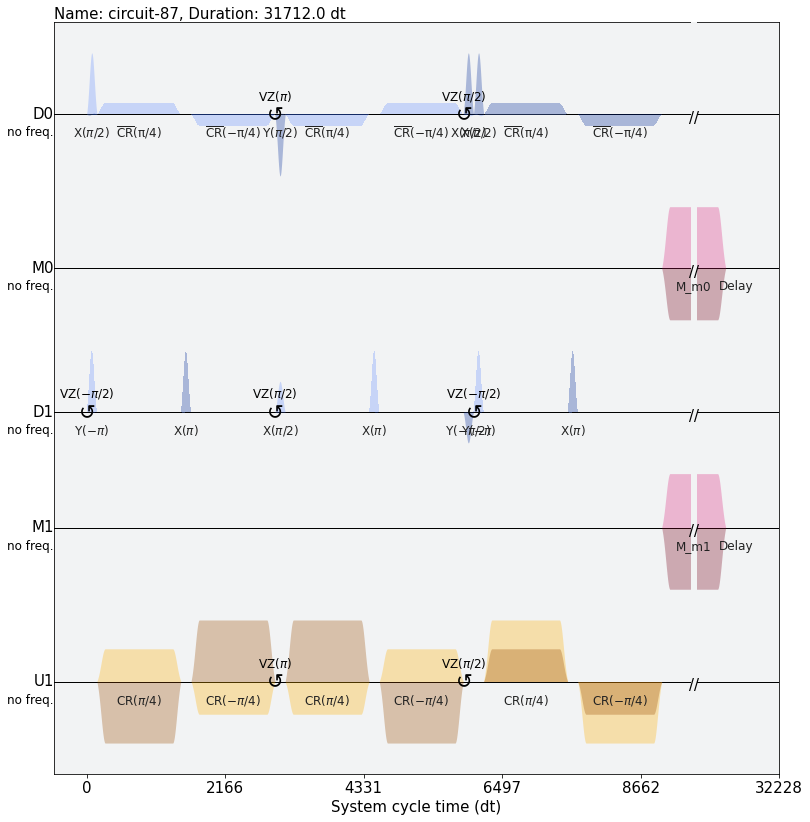

In [22]:
pulse_schedule_swap_orientation.draw()

In [23]:
swap_orientation_duration = pulse_schedule.duration

In [24]:
swap_orientation_duration < standard_orientation_duration 

NameError: name 'standard_orientation_duration' is not defined

Now that we see what this pulse looks like, we can go to the next step of the optimization: Cross gate pulse cancelation. To make this easy to see, I will construct the pulse from above using quantum gates in order to make it easier to visualize

In [25]:
echoed_cr = qiskit.circuit.Gate(name="echoed_cr", num_qubits=2, params=[])


qc_swap_orientation_native = qiskit.QuantumCircuit(2, 2)
qc_swap_orientation_native.rx(np.pi/2, 0)
qc_swap_orientation_native.rz(-np.pi/2, 1)
qc_swap_orientation_native.ry(-np.pi, 1)
qc_swap_orientation_native.add_calibration([echo_cr])
qc_swap_orientation_native.append(echoed_cr, [1, 0])
qc_swap_orientation_native.cnot(1, 0)
qc_swap_orientation_native.measure([0, 1], [0, 1])
print(qc_swap_orientation_native)

     ┌─────────┐           ┌────────────┐┌───┐┌─┐   
q_0: ┤ Rx(π/2) ├───────────┤1           ├┤ X ├┤M├───
     ├─────────┴┐┌────────┐│  echoed_cr │└─┬─┘└╥┘┌─┐
q_1: ┤ Rz(-π/2) ├┤ Ry(-π) ├┤0           ├──■───╫─┤M├
     └──────────┘└────────┘└────────────┘      ║ └╥┘
c: 2/══════════════════════════════════════════╩══╩═
                                               0  1 


We can't simplify the RZ and Rx gates unless they are close to each other, so we will use the identity that X^(1/2) Z = Z X^(1/2) X and move on from there.

In [26]:
pulse_schedule_swap_orientation = qiskit.schedule(qc_swap_orientation, backend)

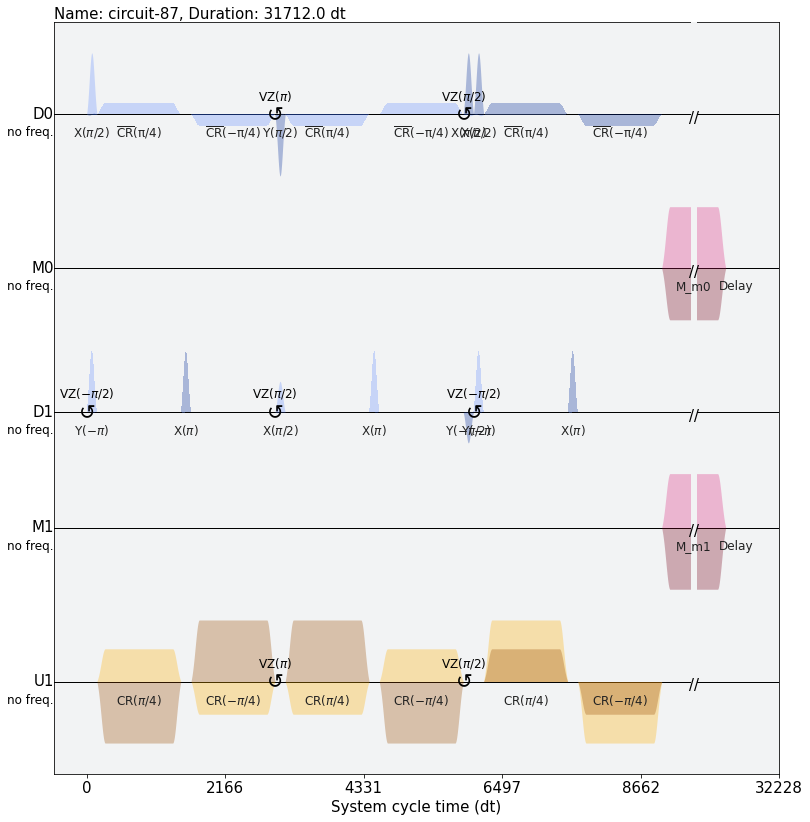

In [27]:
pulse_schedule_swap_orientation.draw()

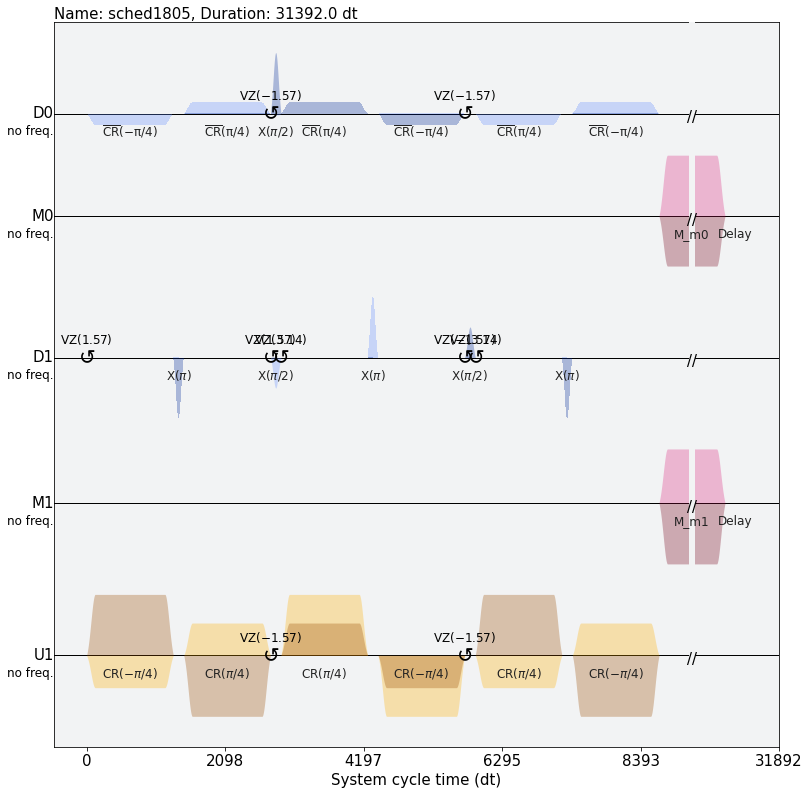

In [6]:
out1 = provider.ibmq_compile(qc1, target="ibmq_bogota_qpu") 
_ = out1.draw()

In [7]:
qc2 = qiskit.QuantumCircuit(2, 2)
qc2.cx(0, 1)
qc2.barrier()
qc2.cx(1, 0)
qc2.barrier()
qc2.cx(0, 1)
qc2.measure([0, 1], [0, 1])
print(qc2)

           ░ ┌───┐ ░      ┌─┐   
q_0: ──■───░─┤ X ├─░───■──┤M├───
     ┌─┴─┐ ░ └─┬─┘ ░ ┌─┴─┐└╥┘┌─┐
q_1: ┤ X ├─░───■───░─┤ X ├─╫─┤M├
     └───┘ ░       ░ └───┘ ║ └╥┘
c: 2/══════════════════════╩══╩═
                           0  1 


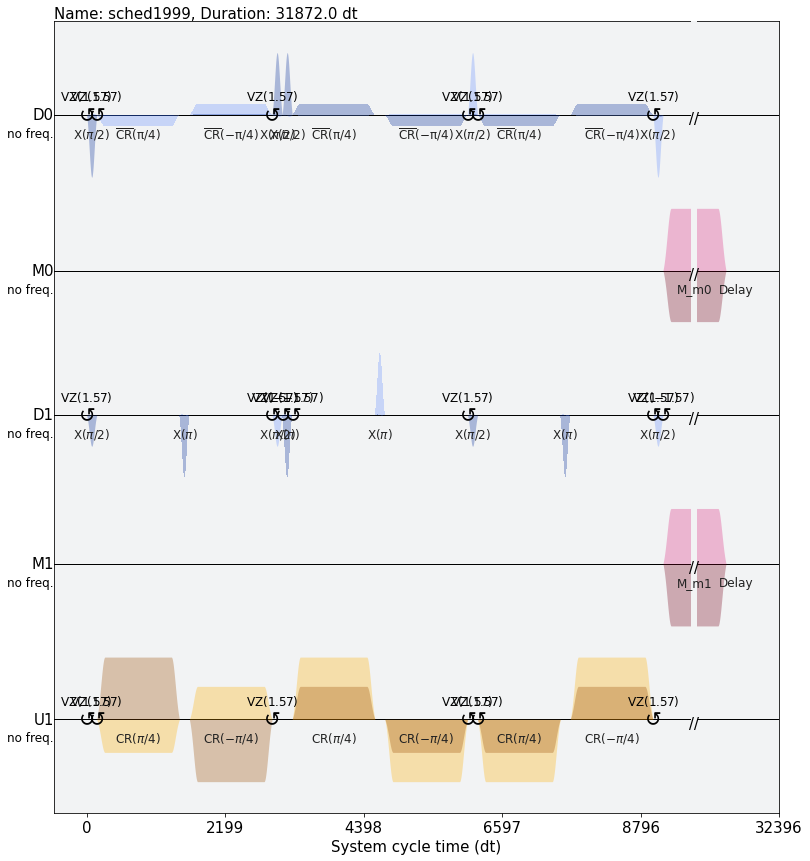

In [8]:
out2 = provider.ibmq_compile(qc2, target="ibmq_bogota_qpu") 
_ = out2.draw()

In [9]:
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
provider = qiskit.IBMQ.providers()[2]

In [11]:
backend = provider.get_backend("ibmq_bogota")

In [12]:
job1 = qiskit.execute(out1, shots=4000, backend=backend)

/Users/pranavgokhale/miniconda3/envs/superstaq-env/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


In [13]:
job2 = qiskit.execute(out2, shots=4000, backend=backend)

In [18]:
job1.status()

<JobStatus.QUEUED: 'job is queued'>

In [19]:
job2.status()

<JobStatus.QUEUED: 'job is queued'>

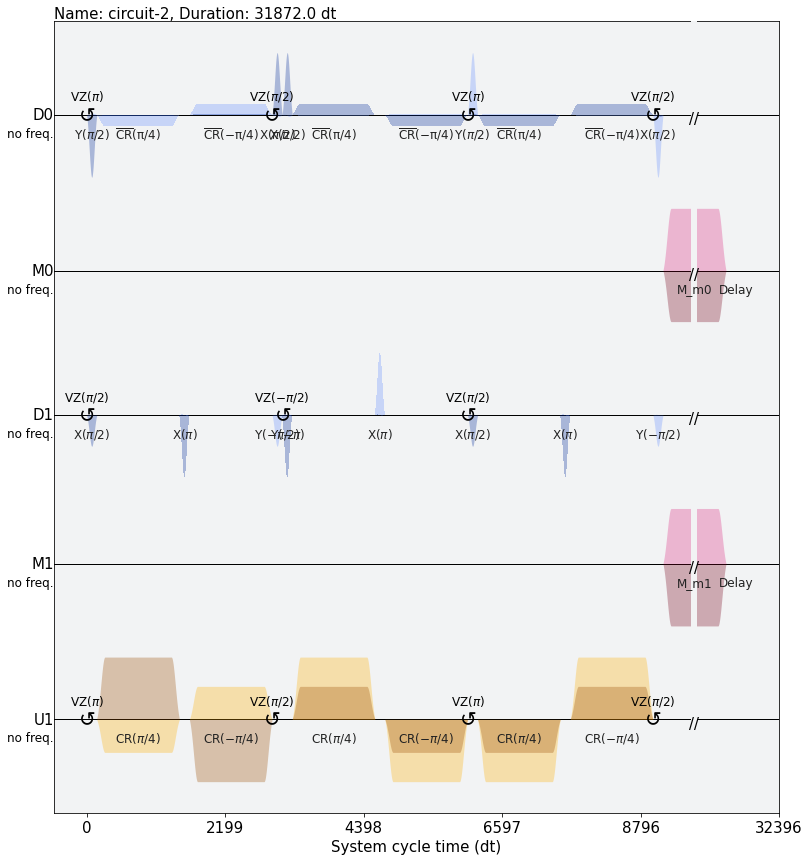

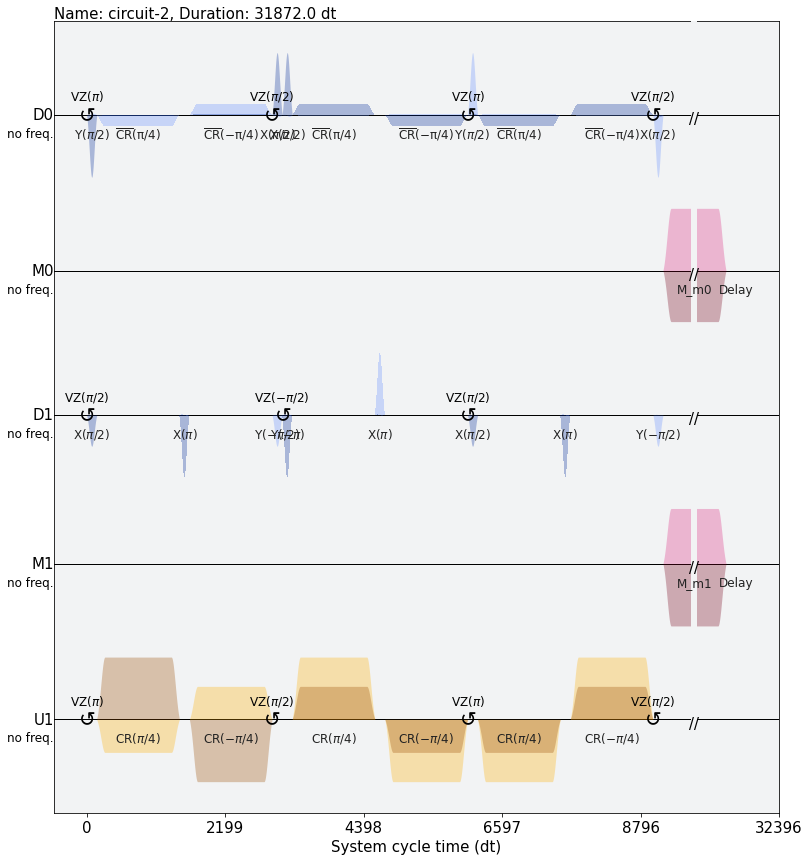

In [17]:
qiskit.schedule(qc2, backend=backend).draw()